# 🏡 Projet Python Avancé : Analyse du Marché Immobilier
**Auteurs :** Ibrahima BA, Mahamat Nour MAHAMAT SULTAN, Moustapha MENDY

## 1. Introduction
Ce notebook présente l'analyse exploratoire et la modélisation des données immobilières extraites du web (SeLoger).
Le pipeline de données a permis de :
1. **Scraper** les annonces (Selenium).
2. **Nettoyer** et structurer les données (Pandas, Regex).
3. **Géolocaliser** les biens (Geopy).

**Objectifs de l'analyse :**
* Comprendre la distribution des prix et des surfaces.
* Identifier les disparités régionales.
* Prédire le prix d'un bien grâce au Machine Learning.

In [ ]:
# --- IMPORTATION DES LIBRAIRIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Configuration esthétique des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✅ Librairies importées.")

✅ Librairies importées.


## 2. Chargement et Audit des Données
Nous chargeons le dataset final, enrichi avec les coordonnées GPS et nettoyé.

In [ ]:
# Chemin vers le fichier généré par le script 'enrichissement_geo_smart.py'
FILE_PATH = "Data/annonces_geo_final.csv"

try:
    df = pd.read_csv(FILE_PATH, sep=";")
    print(f"📂 Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes.")
except FileNotFoundError:
    print("❌ Erreur : Fichier introuvable. Vérifiez le chemin.")

# Aperçu des données
df.head()

📂 Dataset chargé : 2743 lignes, 14 colonnes.


,URL,Date_Scrap,Titre_Nettoye,Prix,Surface,Pieces,Type,Ville,CP,Prix_Estime,Prix_m2,Adresse_Complete,Latitude,Longitude
0,https://www.seloger.com/annonces/achat/apparte...,2025-12-19 10:58:31,Duplex à vendre,310000.0,151.2,5.0,Appartement,Bourg-en-Bresse,1000,False,2050.26,"Bourg-en-Bresse, 1000, France",46.205119,5.225032
1,https://www.seloger.com/annonces/achat/apparte...,2025-12-19 10:59:19,Appartement à vendre,310000.0,151.0,5.0,Appartement,Bourg-en-Bresse,1000,False,2052.98,"Bourg-en-Bresse, 1000, France",46.205119,5.225032
2,https://www.seloger.com/annonces/achat/apparte...,2025-12-19 10:59:25,Appartement à vendre neuf,399900.0,99.0,5.0,Appartement,Bourg-en-Bresse,1000,False,4039.39,"Bourg-en-Bresse, 1000, France",46.205119,5.225032
3,https://www.seloger.com/annonces/achat/apparte...,2025-12-19 10:59:30,Appartement à vendre neuf,226900.0,70.0,3.0,Appartement,Bourg-en-Bresse,1000,False,3241.43,"Bourg-en-Bresse, 1000, France",46.205119,5.225032
4,https://www.seloger.com/annonces/achat/apparte...,2025-12-19 10:59:36,Appartement à vendre neuf,155500.0,38.0,2.0,Appartement,Bourg-en-Bresse,1000,False,4092.11,"Bourg-en-Bresse, 1000, France",46.205119,5.225032


In [ ]:
# --- AUDIT RAPIDE ---
print("Types de données :")
print(df.dtypes)

print("\nValeurs manquantes :")
print(df.isna().sum())

# Nettoyage de sécurité (Conversion types + Suppression NaN critiques)
cols_num = ['Prix', 'Surface', 'Pieces', 'Prix_m2']
for col in cols_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# On remplace les valeurs vides de Pièces par 1 (pour éviter les erreurs graphiques)
df['Pieces'] = df['Pieces'].fillna(1)

# Filtre pour supprimer les données aberrantes (Prix nuls ou Surfaces minuscules)
df_clean = df[(df['Prix'] > 10000) & (df['Surface'] > 9)].copy()
print(f"\n✅ Données prêtes pour analyse : {len(df_clean)} annonces.")

Types de données :
URL                  object
Date_Scrap           object
Titre_Nettoye        object
Prix                float64
Surface             float64
Pieces              float64
Type                 object
Ville                object
CP                    int64
Prix_Estime            bool
Prix_m2             float64
Adresse_Complete     object
Latitude            float64
Longitude           float64
dtype: object

Valeurs manquantes :
URL                   0
Date_Scrap            0
Titre_Nettoye         0
Prix                  0
Surface               0
Pieces              105
Type                  0
Ville                 0
CP                    0
Prix_Estime           0
Prix_m2               0
Adresse_Complete      0
Latitude              0
Longitude             0
dtype: int64

✅ Données prêtes pour analyse : 2740 annonces.


## 3. Analyse Univariée (Distribution)
Observons la répartition des Prix et des Surfaces sur l'ensemble du territoire étudié.

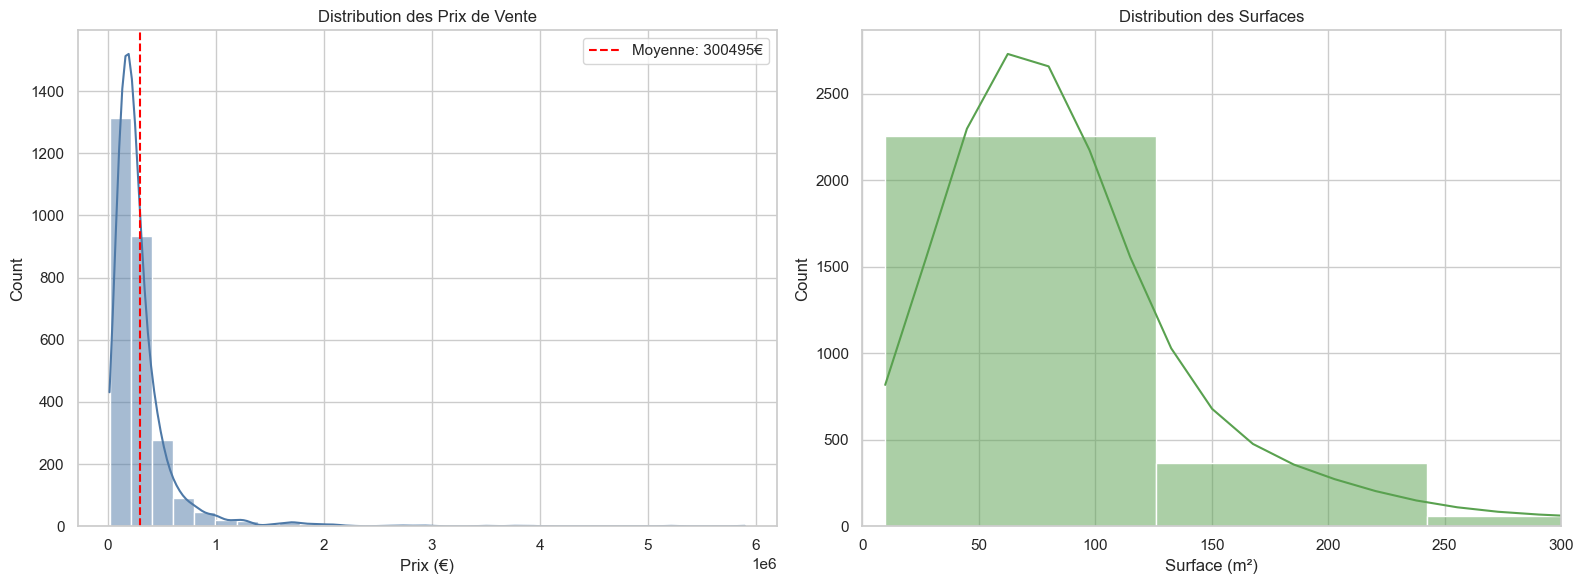

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme des Prix
sns.histplot(df_clean['Prix'], kde=True, ax=axes[0], color='#4e79a7', bins=30)
axes[0].set_title('Distribution des Prix de Vente')
axes[0].set_xlabel('Prix (€)')
axes[0].axvline(df_clean['Prix'].mean(), color='red', linestyle='--', label=f"Moyenne: {int(df_clean['Prix'].mean())}€")
axes[0].legend()

# Histogramme des Surfaces
sns.histplot(df_clean['Surface'], kde=True, ax=axes[1], color='#59a14f', bins=30)
axes[1].set_title('Distribution des Surfaces')
axes[1].set_xlabel('Surface (m²)')
axes[1].set_xlim(0, 300) # Zoom pour lisibilité

plt.tight_layout()
plt.show()

**Interprétation :** La distribution des prix est asymétrique à droite (*right-skewed*), ce qui est typique en immobilier : une majorité de biens "accessibles" et une minorité de biens de luxe qui étirent la courbe.

## 4. Analyse Bivariée et Géographique
Quelles sont les villes les plus chères ? Y a-t-il une corrélation forte entre la surface et le prix ?

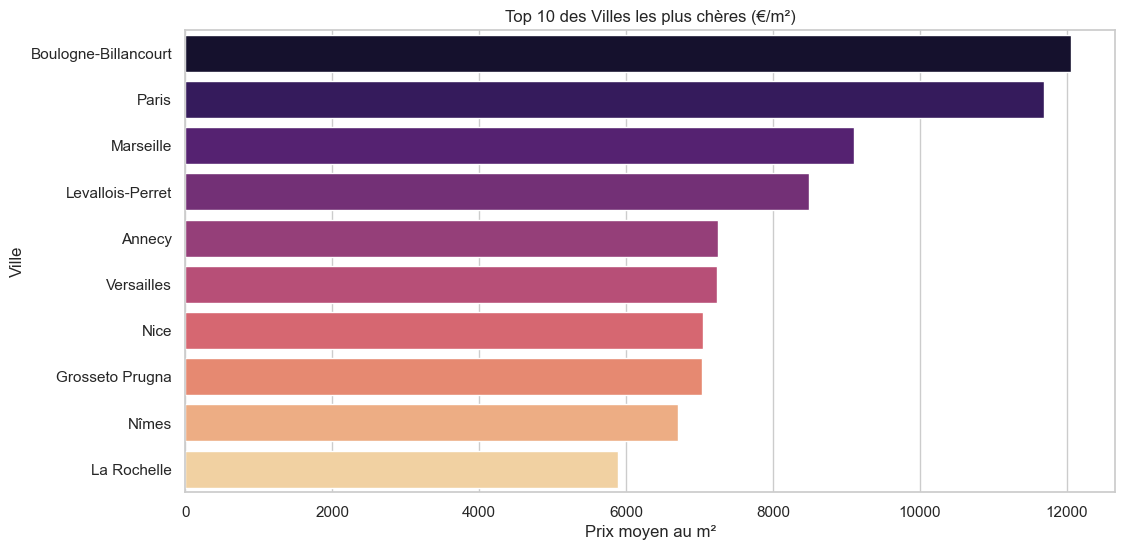

In [ ]:
# --- CLASSEMENT DES VILLES ---
# Calcul du prix moyen au m² par ville
stats_ville = df_clean.groupby('Ville')['Prix_m2'].mean().sort_values(ascending=False).reset_index()

# Top 10
plt.figure(figsize=(12, 6))
sns.barplot(data=stats_ville.head(10), x='Prix_m2', y='Ville', palette='magma')
plt.title('Top 10 des Villes les plus chères (€/m²)')
plt.xlabel('Prix moyen au m²')
plt.show()

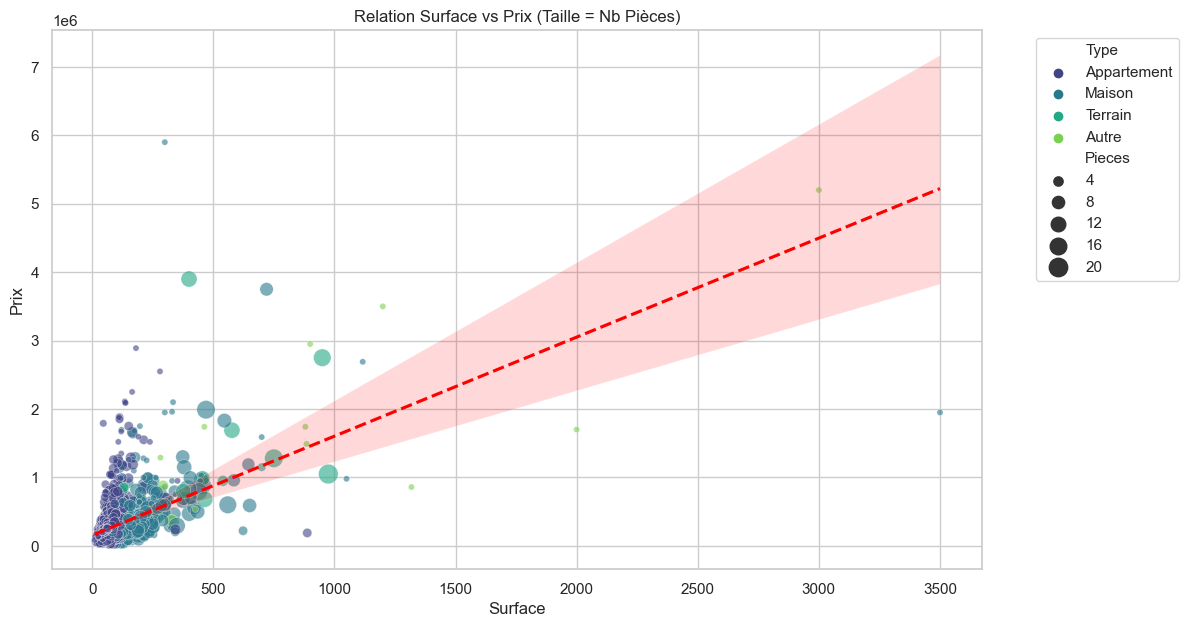

In [ ]:
# --- CORRÉLATION SURFACE vs PRIX ---
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=df_clean,
    x='Surface',
    y='Prix',
    hue='Type',
    size='Pieces',
    sizes=(20, 200),
    alpha=0.6,
    palette='viridis'
)

# Ajout d'une droite de régression
sns.regplot(data=df_clean, x='Surface', y='Prix', scatter=False, color='red', line_kws={'linestyle':'--'})

plt.title('Relation Surface vs Prix (Taille = Nb Pièces)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

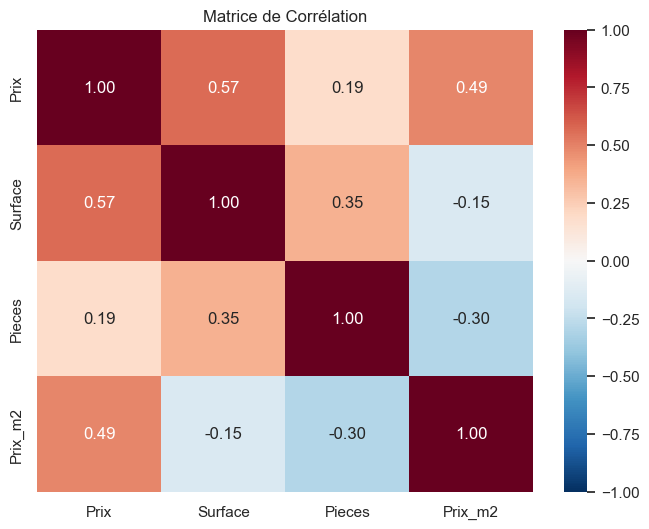

In [ ]:
# --- MATRICE DE CORRÉLATION ---
# Analyse des liens statistiques entre variables numériques
cols_corr = ['Prix', 'Surface', 'Pieces', 'Prix_m2']
corr_mat = df_clean[cols_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='RdBu_r', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

## 5. Cartographie Interactive
Visualisation des clusters d'annonces sur une carte OpenStreetMap via Folium.

In [ ]:
# Création de la carte centrée sur la moyenne des points
if 'Latitude' in df_clean.columns:
    center_lat = df_clean['Latitude'].mean()
    center_lon = df_clean['Longitude'].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    marker_cluster = MarkerCluster().add_to(m)

    # Ajout des marqueurs (Limité aux 1000 premiers pour performance notebook)
    for idx, row in df_clean.head(1000).iterrows():
        if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
            color = "blue" if row['Type'] == 'Appartement' else "green"
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=f"<b>{row['Ville']}</b><br>{row['Prix']}€<br>{row['Surface']}m²",
                icon=folium.Icon(color=color, icon="home")
            ).add_to(marker_cluster)

    # Affichage de la carte
    display(m)
else:
    print("⚠️ Coordonnées GPS manquantes.")

## 6. Machine Learning : Prédiction de Prix
Nous utilisons un modèle de **Régression Linéaire Simple** pour estimer le prix d'un bien en fonction de sa surface.
C'est une option avancée du cahier des charges.

In [ ]:
# 1. Sélection des variables
X = df_clean[['Surface']] # Feature
y = df_clean['Prix']      # Target

# 2. Séparation Train / Test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entraînement
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Prédiction et Évaluation
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"📊 R² Score (Précision) : {r2:.2f}")
print(f"📉 Erreur Moyenne Absolue (MAE) : {int(mae):,} €")

📊 R² Score (Précision) : 0.51
📉 Erreur Moyenne Absolue (MAE) : 144,395 €


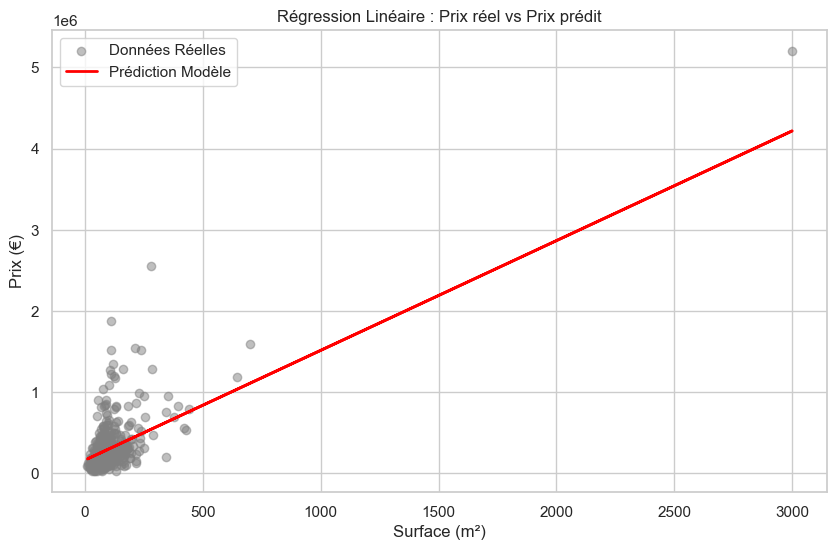

In [ ]:
# --- VISUALISATION DES RÉSULTATS DU MODÈLE ---
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='gray', alpha=0.5, label='Données Réelles')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Prédiction Modèle')
plt.title('Régression Linéaire : Prix réel vs Prix prédit')
plt.xlabel('Surface (m²)')
plt.ylabel('Prix (€)')
plt.legend()
plt.show()

In [ ]:
# --- TEST INTERACTIF ---
# Exemple : Combien coûterait un appartement de 50m² selon notre modèle ?
surf_input = np.array([[50]])
prix_predit = model.predict(surf_input)[0]

print(f"🏠 Estimation IA : Un bien de 50 m² est estimé à environ {int(prix_predit):,} € sur ce marché.")

🏠 Estimation IA : Un bien de 50 m² est estimé à environ 233,508 € sur ce marché.


C:\Users\utilisateurm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## 7. Conclusion
Ce projet a permis de démontrer la faisabilité d'une chaîne de traitement de données complète :
1. Les données ont été extraites malgré les protections anti-bot.
2. Le nettoyage intelligent a permis de récupérer des données partielles.
3. L'analyse montre une forte corrélation Surface/Prix, mais avec de fortes disparités locales.
4. Le modèle prédictif offre une première base d'estimation, qui pourrait être améliorée en intégrant la localisation (Ville) comme variable.